In [1]:
from hossam import *
from pandas import DataFrame, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

from scipy.spatial import ConvexHull

from 성능평가함수 import *

In [2]:
origin=load_data('dogs')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

닥스훈트와 진돗개의 몸 길이와 키를 조사한 가상 데이터

===== 데이터 크기 확인 =====
데이터셋 크기 : (200, 3)
행 개수 : 200개
열 개수 : 3개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dog     200 non-null    object 
 1   length  200 non-null    float64
 2   height  200 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.8+ KB
None


,dog,length,height
0,d,55.010,29.270
1,d,59.010,29.390
2,d,56.530,28.500
3,d,53.660,28.500
4,d,49.670,31.970


In [3]:
df=origin.astype({'dog':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   dog     200 non-null    category
 1   length  200 non-null    float64 
 2   height  200 non-null    float64 
dtypes: category(1), float64(2)
memory usage: 3.6 KB


In [4]:
hs_describe(df)

,count,na_count,na_rate,mean,std,min,25%,50%,75%,max,iqr,up,down,outlier_count,outlier_rate,skew,dist,log_need
length,200.000,0,0.000,53.795,5.506,39.940,50.222,53.445,56.900,68.310,6.678,66.916,40.206,3,1.500,0.224,거의 대칭,낮음
height,200.000,0,0.000,41.675,10.036,22.760,31.965,43.785,51.185,55.870,19.220,80.015,3.135,0,0.000,-0.170,거의 대칭,낮음


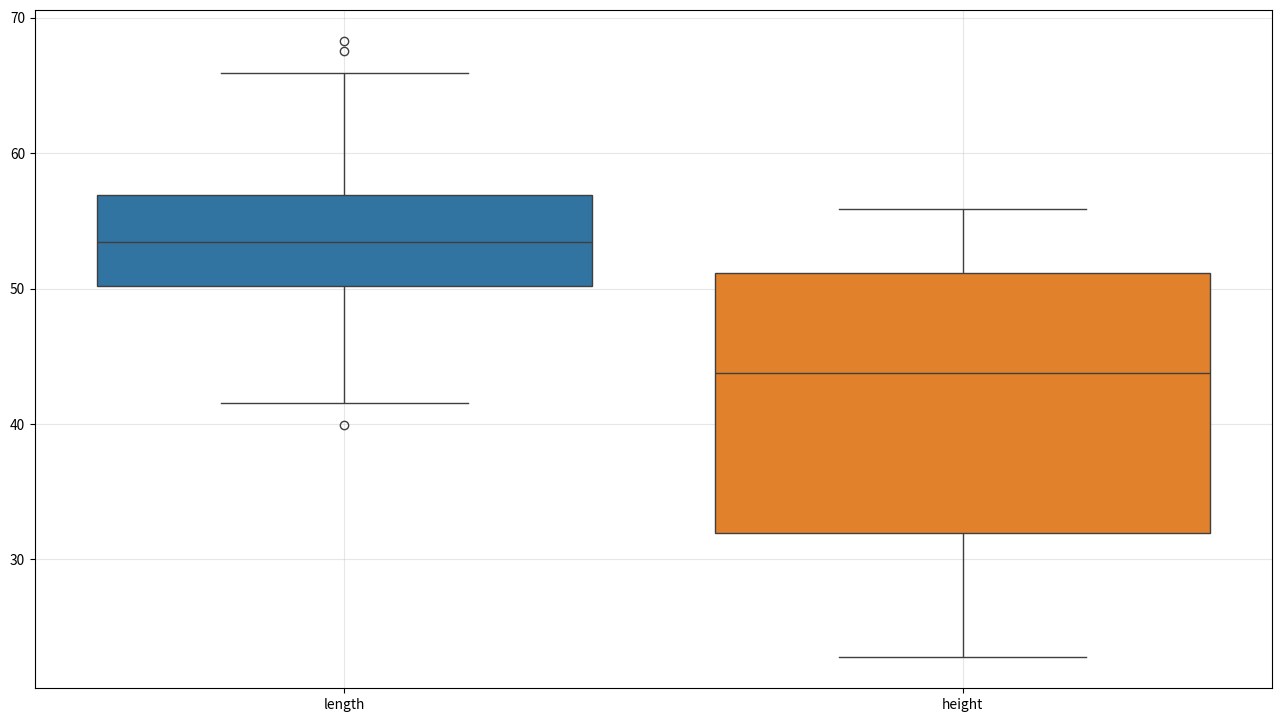

In [5]:
my_dpi=100
figsize=(1280/my_dpi, 720/my_dpi)
fig, ax=plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.boxplot(data=origin, orient='v')

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [6]:
a, b=category_describe(df)
display(a)
display(b)

,변수,범주,빈도,비율(%)
0,dog,d,100,50.000
1,dog,j,100,50.000


,최다 범주,최다_비율(%),최소_범주,최소_비율(%)
변수,,,,
dog,d,50.000,j,50.000


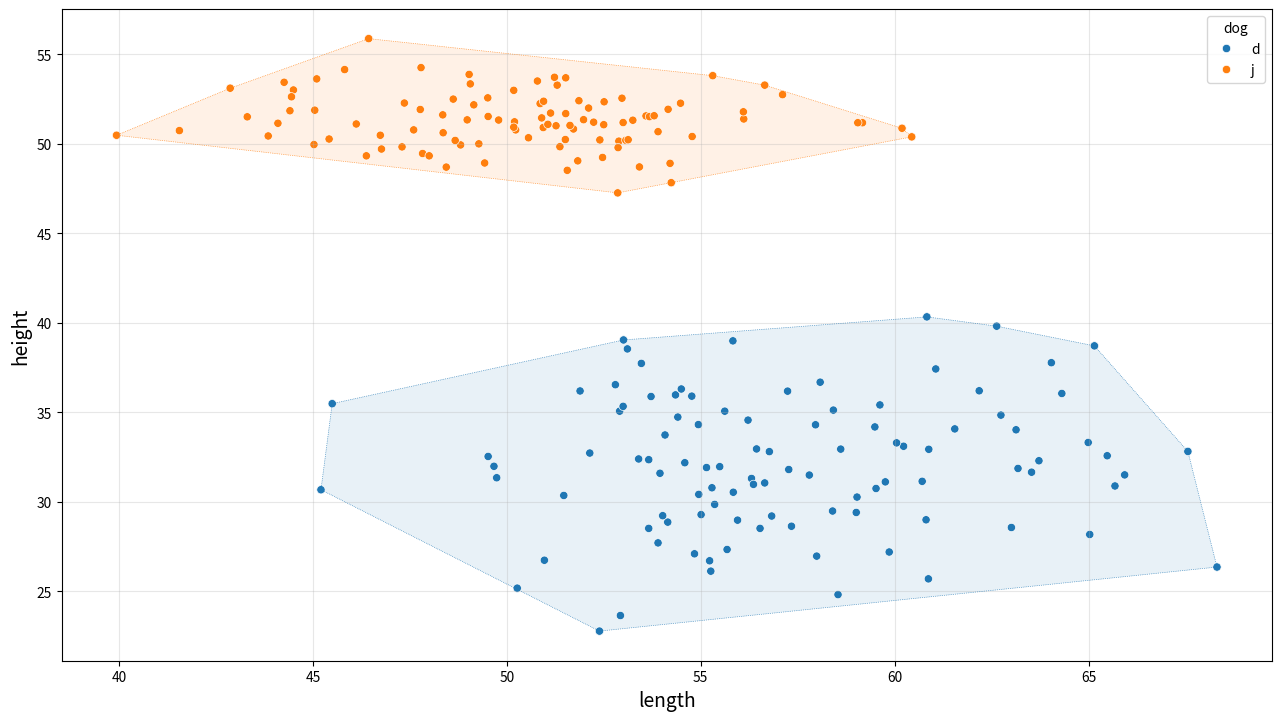

In [7]:
vdf=df.copy()
hue_field='dog'
x_field='length'
y_field='height'
my_dpi=100

figsize=(1280/my_dpi, 720/my_dpi)
fig, ax=plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

for c in vdf[hue_field].unique():
    df_c=vdf.loc[vdf[hue_field]==c, [x_field, y_field]]

    try:
        hull=ConvexHull(df_c)
        points=np.append(hull.vertices, hull.vertices[0])
        ax.plot(df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth=0.5, linestyle=':')
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
    except:
        pass

sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [8]:
df2=df.copy()
df2['dog']=df2['dog'].map({'d':0, 'j':1})
display(df2.head())
df2.info()

,dog,length,height
0,0,55.010,29.270
1,0,59.010,29.390
2,0,56.530,28.500
3,0,53.660,28.500
4,0,49.670,31.970


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   dog     200 non-null    category
 1   length  200 non-null    float64 
 2   height  200 non-null    float64 
dtypes: category(1), float64(2)
memory usage: 3.6 KB


In [10]:
df3=df2.copy()
yname='dog'
x=df3.drop(columns=[yname])
y=df3[yname]

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.25, random_state=52)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((150, 2), (50, 2), (150,), (50,))

In [11]:
pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=52))
])

param_grid={
    'model__penalty':['l2'],
    'model__solver':['lbfgs'],
    'model__C':[0.01, 0.1, 1, 10, 100],
    'model__max_iter':[100, 300, 500],
    'model__class_weight':[None, 'balanced']
}

gs=GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

gs.fit(x_train, y_train)

estimator=gs.best_estimator_
estimator

Pipeline(steps=[('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.01, random_state=52))])

In [12]:
y_pred=estimator.predict(x_test)
y_pred

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1], dtype=int64)

In [13]:
df4=x_test.copy()
df4['y_test']=y_test
df4['y_pred']=y_pred
df4.head()

,length,height,y_test,y_pred
119,54.480,52.260,1,1
62,59.030,30.250,0,0
132,55.310,53.800,1,1
114,42.870,53.100,1,1
104,56.110,51.380,1,1


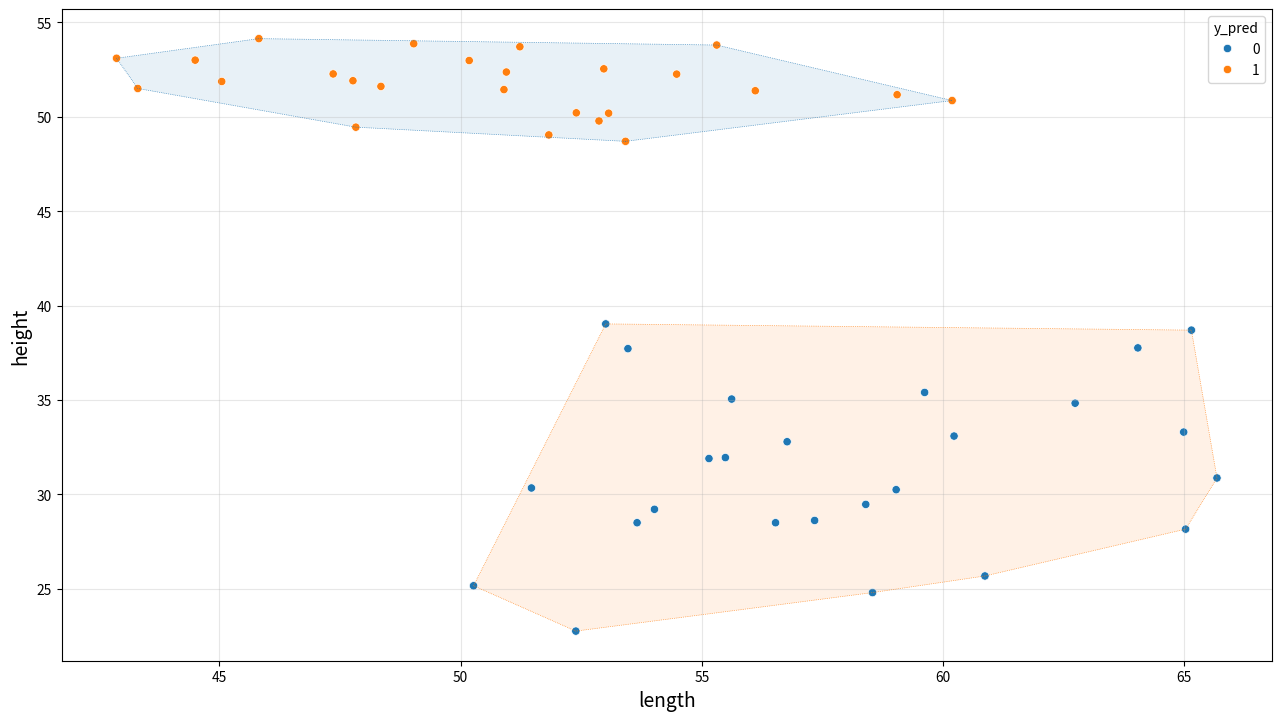

In [14]:
vdf=df4.copy()
hue_field='y_pred'
x_field='length'
y_field='height'

figsize=(1280/my_dpi, 720/my_dpi)
fig, ax=plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

for c in vdf[hue_field].unique():
    df_c=vdf.loc[vdf[hue_field]==c, [x_field, y_field]]

    try:
        hull=ConvexHull(df_c)
        points=np.append(hull.vertices, hull.vertices[0])
        ax.plot(df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth=0.5, linestyle=':')
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha=0.1)
    except:
        pass

sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

In [15]:
input_df=DataFrame({'length':[47, 39, 52], 'height':[23, 42, 49]})
input_df['y_pred']=estimator.predict(input_df)
input_df

,length,height,y_pred
0,47,23,0
1,39,42,1
2,52,49,1
